# Practice Goals for this Version:

In this version I want to spend more time applying performance analysis techniques, from CM to ROC and AUC in comparing models and their decision thresholds.

I have understood the performance analysis, now it is time to apply it.

# Debrief

Well well, debrief.

I did get a better feel for cm, sensitivity and specificity. 
For example, all models were prone to make false negative mistakes which were leading to lower sensitivity scores than specificity. 

Still not sure why use recall/precision over simple sens/spec. ROC curve wasn't helpful in comparing models, AUC was, but F1 was even better.

Kind of understood how decision threshold influences sens/spec results, playing with it in a log model to balance the metrics. 

Have somewhat better intuition, but still lot of practice on other datasets to go.


In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load


import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from pandas import Series, DataFrame
import matplotlib.pyplot as plt

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session


import matplotlib.pyplot as plt

plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


In [2]:
train = pd.read_csv("/kaggle/input/titanic/train.csv")
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
test = pd.read_csv("/kaggle/input/titanic/test.csv")
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [4]:
gen_sub = pd.read_csv("/kaggle/input/titanic/gender_submission.csv")
gen_sub.head()

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1


# Data Exploration

In [ ]:
train.info()

In [ ]:
test.info()

In [ ]:
train.Fare.plot(kind="hist", bins=50)

In [ ]:
train.Age.plot(kind="hist", bins=30)
#train.Parch.plot(kind="hist", bins=30)
#train.SibSp.plot(kind="hist", bins=30)

In [ ]:
#train.plot(x="Survived", y="Pclass", kind="scatter")
#pd.crosstab(train.Pclass, train.Survived)
counts = train.groupby(["Pclass", "Survived"]).size().unstack()
counts.plot(kind="bar")

In [ ]:
counts = train.groupby(["Embarked", "Survived"]).size().unstack()
counts.plot(kind="bar")

In [ ]:
counts = train.groupby(["Parch", "Survived"]).size().unstack()
counts.plot(kind="bar")
# seems like it helps to have family members

In [ ]:
# Does missing age correlates with the class passenger is in?

# Calculate missing age percentage by class
missing_pct = train.groupby('Pclass')['Age'].apply(lambda x: x.isna().mean() * 100)

# Plot it
missing_pct.plot(kind='bar', figsize=(6, 4), color=['#1f77b4', '#ff7f0e', '#2ca02c'])
plt.title('Missing Age % by Passenger Class')
plt.xlabel('Passenger Class')
plt.ylabel('Missing %')
plt.xticks(rotation=0)
plt.show()

print(missing_pct)

# Handle Missing Values

Previously for handling missing age values I used simple median across all train and test sets, now we'll use more sophisticated approaches. 

Specifically, we'll first merge train and test sets, then group passengers by sex and class, and then impute the mean of each group. 

(In the future versions final improvement we'll be using extracted titles from names.)

In [5]:
# Merging datasets.
combined = pd.concat([train, test], axis=0, ignore_index=True)
combined.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [6]:
# Step 1: Extract titles from the Name column
combined['Title'] = combined['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)

# Step 2: Group titles
TitleDict = {"Capt": "Officer","Col": "Officer","Major": "Officer","Jonkheer": "Royalty", \
             "Don": "Royalty", "Sir" : "Royalty","Dr": "Royalty","Rev": "Royalty", \
             "Countess":"Royalty", "Mme": "Mrs", "Mlle": "Miss", "Ms": "Mrs","Mr" : "Mr", \
             "Mrs" : "Mrs","Miss" : "Miss","Master" : "Master","Lady" : "Royalty"}

# Map titles to categories
combined['Title'] = combined['Title'].map(TitleDict)

# Step 3: Calculate mean age by Title and Pclass groups
age_stats = combined.groupby(['Title', 'Pclass'])['Age'].agg(['mean', 'count', 'std'])
print(age_stats)

                     mean  count        std
Title   Pclass                             
Master  1        6.984000      5   4.974061
        2        2.757273     11   2.723942
        3        6.090000     37   4.152566
Miss    1       30.131148     61  11.528914
        2       20.717083     48  12.207963
        3       17.360874    103   9.935434
Mr      1       41.450758    132  13.489020
        2       32.346715    137  11.862038
        3       28.318910    312   9.907858
Mrs     1       42.926471     68  14.122403
        2       33.418182     55  10.422005
        3       32.326531     49  10.194745
Officer 1       54.714286      7   8.440266
Royalty 1       43.600000     10   7.441625
        2       40.700000     10  12.927576


In [7]:
# Impute missing ages
combined['Age'] = combined.groupby(['Title', 'Pclass'])['Age'].transform(lambda x: x.fillna(x.mean()))

# Check if imputation worked
print(f"Missing ages: {combined['Age'].isnull().sum()}")

Missing ages: 1


In [8]:
display(combined[combined.Title.isnull()])

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
1305,1306,NaN,1,"Oliva y Ocana, Dona. Fermina",female,NaN,0,0,PC 17758,108.9,C105,C,NaN


In [9]:
combined.at[1305,'Title'] = 'Royalty'
combined.at[1305,'Age'] = 43.6

In [10]:
combined.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  1309 non-null   int64  
 1   Survived     891 non-null    float64
 2   Pclass       1309 non-null   int64  
 3   Name         1309 non-null   object 
 4   Sex          1309 non-null   object 
 5   Age          1309 non-null   float64
 6   SibSp        1309 non-null   int64  
 7   Parch        1309 non-null   int64  
 8   Ticket       1309 non-null   object 
 9   Fare         1308 non-null   float64
 10  Cabin        295 non-null    object 
 11  Embarked     1307 non-null   object 
 12  Title        1309 non-null   object 
dtypes: float64(3), int64(4), object(6)
memory usage: 133.1+ KB


Cabin will be converted to binary "has cabin". Which will have to be numeric 0/1.

In [11]:
combined['HasCabin'] = combined['Cabin'].notna().astype(int)
combined = combined.drop('Cabin', axis=1)

combined.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  1309 non-null   int64  
 1   Survived     891 non-null    float64
 2   Pclass       1309 non-null   int64  
 3   Name         1309 non-null   object 
 4   Sex          1309 non-null   object 
 5   Age          1309 non-null   float64
 6   SibSp        1309 non-null   int64  
 7   Parch        1309 non-null   int64  
 8   Ticket       1309 non-null   object 
 9   Fare         1308 non-null   float64
 10  Embarked     1307 non-null   object 
 11  Title        1309 non-null   object 
 12  HasCabin     1309 non-null   int64  
dtypes: float64(3), int64(5), object(5)
memory usage: 133.1+ KB


Missing fare instances will be replaced with median, while missing embarked with mode.

In [12]:
embarked_mode = combined['Embarked'].mode()[0]  # mode() returns a Series, so we take first value
combined['Embarked'].fillna(embarked_mode, inplace=True)
combined['Fare'].fillna(combined['Fare'].median(), inplace=True)

combined.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  1309 non-null   int64  
 1   Survived     891 non-null    float64
 2   Pclass       1309 non-null   int64  
 3   Name         1309 non-null   object 
 4   Sex          1309 non-null   object 
 5   Age          1309 non-null   float64
 6   SibSp        1309 non-null   int64  
 7   Parch        1309 non-null   int64  
 8   Ticket       1309 non-null   object 
 9   Fare         1309 non-null   float64
 10  Embarked     1309 non-null   object 
 11  Title        1309 non-null   object 
 12  HasCabin     1309 non-null   int64  
dtypes: float64(3), int64(5), object(5)
memory usage: 133.1+ KB


/tmp/ipykernel_36/2776746238.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  combined['Embarked'].fillna(embarked_mode, inplace=True)
/tmp/ipykernel_36/2776746238.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', 

# Feature Selection
To limit the complexity of data (and save myself time for this version), I will drop Ticket, Name and PassengerId (it's test values will be used later for submission).

In [13]:
combined = combined.drop(['Ticket', 'Name', 'PassengerId', 'Title'], axis=1)
combined.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,HasCabin
0,0.0,3,male,22.0,1,0,7.2500,S,0
1,1.0,1,female,38.0,1,0,71.2833,C,1
2,1.0,3,female,26.0,0,0,7.9250,S,0
3,1.0,1,female,35.0,1,0,53.1000,S,1
4,0.0,3,male,35.0,0,0,8.0500,S,0


# Encoding Categorical Variables
For Sex numerical 0/1. For embarked one-hot encoding.

In [14]:
combined['Sex'] = combined["Sex"].map({'male':0,'female':1})
combined.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,HasCabin
0,0.0,3,0,22.0,1,0,7.2500,S,0
1,1.0,1,1,38.0,1,0,71.2833,C,1
2,1.0,3,1,26.0,0,0,7.9250,S,0
3,1.0,1,1,35.0,1,0,53.1000,S,1
4,0.0,3,0,35.0,0,0,8.0500,S,0


In [15]:
# Creates 3 columns: Embarked_C, Embarked_Q, Embarked_S
embarked_encoded = pd.get_dummies(combined['Embarked'], prefix='Embarked')
combined = pd.concat([combined.drop('Embarked', axis=1), embarked_encoded], axis=1)
combined.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,HasCabin,Embarked_C,Embarked_Q,Embarked_S
0,0.0,3,0,22.0,1,0,7.2500,0,False,False,True
1,1.0,1,1,38.0,1,0,71.2833,1,True,False,False
2,1.0,3,1,26.0,0,0,7.9250,0,False,False,True
3,1.0,1,1,35.0,1,0,53.1000,1,False,False,True
4,0.0,3,0,35.0,0,0,8.0500,0,False,False,True


# Outlier Handling

Percentage clipping for Fare feature (recommended by Claude, not my level yet to differentiate which techniques are better depending on the case).

In [16]:
print(combined['Fare'].describe())
print(f"95th percentile: ${combined['Fare'].quantile(0.95):.2f}")
print(f"97th percentile: ${combined['Fare'].quantile(0.97):.2f}")
print(f"975th percentile: ${combined['Fare'].quantile(0.975):.2f}")
print(f"98th percentile: ${combined['Fare'].quantile(0.98):.2f}")
print(f"99th percentile: ${combined['Fare'].quantile(0.99):.2f}")

count    1309.000000
mean       33.281086
std        51.741500
min         0.000000
25%         7.895800
50%        14.454200
75%        31.275000
max       512.329200
Name: Fare, dtype: float64
95th percentile: $133.65
97th percentile: $164.87
975th percentile: $211.50
98th percentile: $221.78
99th percentile: $262.38


<Axes: ylabel='Frequency'>

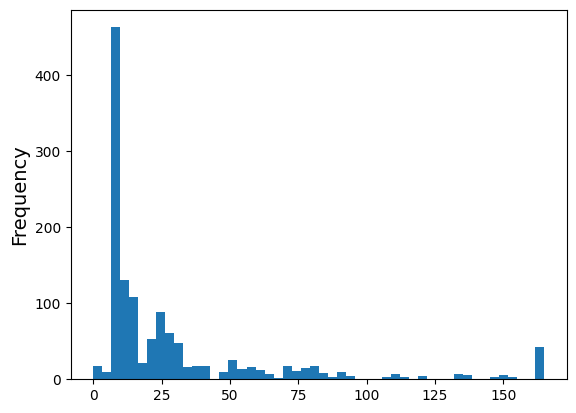

In [17]:
fare_cap = combined['Fare'].quantile(0.97)
combined['Fare'] = combined['Fare'].clip(upper=fare_cap)
combined.Fare.plot(kind="hist", bins=50)

# Feature Engineering

In this version I'll create a single feature of N_of_rel on titanic, which is SibSp+Parch.

In [18]:
combined['n_of_rel'] = combined['SibSp'] + combined['Parch']
combined = combined.drop(['SibSp', 'Parch'], axis=1)

combined.head()

,Survived,Pclass,Sex,Age,Fare,HasCabin,Embarked_C,Embarked_Q,Embarked_S,n_of_rel
0,0.0,3,0,22.0,7.2500,0,False,False,True,1
1,1.0,1,1,38.0,71.2833,1,True,False,False,1
2,1.0,3,1,26.0,7.9250,0,False,False,True,0
3,1.0,1,1,35.0,53.1000,1,False,False,True,1
4,0.0,3,0,35.0,8.0500,0,False,False,True,0


In [19]:
combined.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Survived    891 non-null    float64
 1   Pclass      1309 non-null   int64  
 2   Sex         1309 non-null   int64  
 3   Age         1309 non-null   float64
 4   Fare        1309 non-null   float64
 5   HasCabin    1309 non-null   int64  
 6   Embarked_C  1309 non-null   bool   
 7   Embarked_Q  1309 non-null   bool   
 8   Embarked_S  1309 non-null   bool   
 9   n_of_rel    1309 non-null   int64  
dtypes: bool(3), float64(3), int64(4)
memory usage: 75.5 KB


# Feature Scaling
Previously I used standard scaler, but because some of the data is skewed, like fare price, I'll apply robust scaler.

In [20]:
from sklearn.preprocessing import RobustScaler

# Exclude survived from scaling and scale
cols_to_scale = combined.columns.drop("Survived")
rob_scale = RobustScaler()
combined_scaled = rob_scale.fit_transform(combined[cols_to_scale])

# Remerge
combined_final = pd.DataFrame(combined_scaled, columns=cols_to_scale)
combined_final['Survived'] = combined['Survived'].values

combined_final.head()

,Pclass,Sex,Age,Fare,HasCabin,Embarked_C,Embarked_Q,Embarked_S,n_of_rel,Survived
0,0.0,0.0,-0.407672,-0.308146,0.0,0.0,0.0,0.0,1.0,0.0
1,-2.0,1.0,0.624586,2.430755,1.0,1.0,0.0,-1.0,1.0,1.0
2,0.0,1.0,-0.149607,-0.279274,0.0,0.0,0.0,0.0,0.0,1.0
3,-2.0,1.0,0.431038,1.652999,1.0,0.0,0.0,0.0,1.0,1.0
4,0.0,0.0,0.431038,-0.273927,0.0,0.0,0.0,0.0,0.0,0.0


# Training the Model!

In [21]:
# First, separate the training and test sets.

# Split based on NaN in Survived column
train_final = combined_final[combined_final['Survived'].notna()].copy()
test_final = combined_final[combined_final['Survived'].isna()].copy()

# For train set, convert Survived to int (it's probably float due to NaNs)
train_final['Survived'] = train_final['Survived'].astype(int)

# For test set, you probably want to drop the Survived column
test_final = test_final.drop('Survived', axis=1)

In [22]:
# Final dataset prep before training

x_train = train_final.drop("Survived", axis=1)
y_train = train_final["Survived"]
x_test = test_final

In [23]:
x_train.head()
#y_train.head()
#x_test.head()

,Pclass,Sex,Age,Fare,HasCabin,Embarked_C,Embarked_Q,Embarked_S,n_of_rel
0,0.0,0.0,-0.407672,-0.308146,0.0,0.0,0.0,0.0,1.0
1,-2.0,1.0,0.624586,2.430755,1.0,1.0,0.0,-1.0,1.0
2,0.0,1.0,-0.149607,-0.279274,0.0,0.0,0.0,0.0,0.0
3,-2.0,1.0,0.431038,1.652999,1.0,0.0,0.0,0.0,1.0
4,0.0,0.0,0.431038,-0.273927,0.0,0.0,0.0,0.0,0.0


## Shortlisting models on k-fold cross validation scores

In [24]:
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier

knn = KNeighborsClassifier(n_neighbors=5)
log = LogisticRegression(max_iter=1000, random_state=42)
rfc = RandomForestClassifier(n_estimators=100, random_state=42)
svm = SVC(kernel='rbf', random_state=42)
xgb = XGBClassifier(n_estimators = 100, random_state=42, eval_metric="logloss")

cv_scores_knn = cross_val_score(knn, x_train, y_train, cv=5, scoring='accuracy')
cv_scores_log = cross_val_score(log, x_train, y_train, cv=5, scoring='accuracy')
cv_scores_rfc = cross_val_score(rfc, x_train, y_train, cv=5, scoring='accuracy')
cv_scores_svm = cross_val_score(svm, x_train, y_train, cv=5, scoring='accuracy')
cv_scores_xgb = cross_val_score(xgb, x_train, y_train, cv=5, scoring='accuracy')

print(cv_scores_knn.mean(), cv_scores_knn.std())
print(cv_scores_log.mean(), cv_scores_log.std())
print(cv_scores_rfc.mean(), cv_scores_rfc.std())
print(cv_scores_svm.mean(), cv_scores_svm.std())
print(cv_scores_xgb.mean(), cv_scores_xgb.std())

0.782298662984119 0.026623750623209565
0.794620551126734 0.0114147682726962
0.8137028435126483 0.02043070434602062
0.8193082669010107 0.021979466450153792
0.8137153976523759 0.027437736549786856


# Performance Analysis

## Confusion Matrices

In [34]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix

y_train_knn = cross_val_predict(knn, x_train, y_train, cv=5)
cm_knn = confusion_matrix(y_train, y_train_knn)
print('cm_knn')
print(cm_knn)
print('-----')

y_train_log = cross_val_predict(log, x_train, y_train, cv=5)
cm_log = confusion_matrix(y_train, y_train_log)
print('cm_log')
print(cm_log)
print('-----')

y_train_rfc = cross_val_predict(rfc, x_train, y_train, cv=5)
cm_rfc = confusion_matrix(y_train, y_train_rfc)
print('cm_rfc')
print(cm_rfc)
print('-----')

y_train_svm = cross_val_predict(svm, x_train, y_train, cv=5)
cm_svm = confusion_matrix(y_train, y_train_svm)
print('cm_svm')
print(cm_svm)
print('-----')

y_train_xgb = cross_val_predict(xgb, x_train, y_train, cv=5)
cm_xgb = confusion_matrix(y_train, y_train_xgb)
print('cm_xgb')
print(cm_xgb)
print('-----')

cm_knn
[[458  91]
 [103 239]]
-----
cm_log
[[471  78]
 [105 237]]
-----
cm_rfc
[[469  80]
 [ 86 256]]
-----
cm_svm
[[482  67]
 [ 94 248]]
-----
cm_xgb
[[472  77]
 [ 89 253]]
-----


What is noticeable, is that all models are skewed to make false negatives.

Wait, but are they or is it just that there are more positive than negative cases?

I presume to test that I just need to calculate the sensitivity vs specificity ratios.

In [63]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix

# KNN Model
y_train_knn = cross_val_predict(knn, x_train, y_train, cv=5)
cm_knn = confusion_matrix(y_train, y_train_knn)
tn, fp, fn, tp = cm_knn.ravel()
sensitivity_knn = tp / (tp + fn)
specificity_knn = tn / (tn + fp)
print('KNN:')
print(f'Sensitivity: {sensitivity_knn:.4f}, Specificity: {specificity_knn:.4f}')
print('-----')

# Logistic Regression Model
y_train_log = cross_val_predict(log, x_train, y_train, cv=5)
cm_log = confusion_matrix(y_train, y_train_log)
tn, fp, fn, tp = cm_log.ravel()
sensitivity_log = tp / (tp + fn)
specificity_log = tn / (tn + fp)
print('Logistic Regression:')
print(f'Sensitivity: {sensitivity_log:.4f}, Specificity: {specificity_log:.4f}')
print('-----')

# Random Forest Model
y_train_rfc = cross_val_predict(rfc, x_train, y_train, cv=5)
cm_rfc = confusion_matrix(y_train, y_train_rfc)
tn, fp, fn, tp = cm_rfc.ravel()
sensitivity_rfc = tp / (tp + fn)
specificity_rfc = tn / (tn + fp)
print('Random Forest:')
print(f'Sensitivity: {sensitivity_rfc:.4f}, Specificity: {specificity_rfc:.4f}')
print('-----')

# SVM Model
y_train_svm = cross_val_predict(svm, x_train, y_train, cv=5)
cm_svm = confusion_matrix(y_train, y_train_svm)
tn, fp, fn, tp = cm_svm.ravel()
sensitivity_svm = tp / (tp + fn)
specificity_svm = tn / (tn + fp)
print('SVM:')
print(f'Sensitivity: {sensitivity_svm:.4f}, Specificity: {specificity_svm:.4f}')
print('-----')

# XGBoost Model
y_train_xgb = cross_val_predict(xgb, x_train, y_train, cv=5)
cm_xgb = confusion_matrix(y_train, y_train_xgb)
tn, fp, fn, tp = cm_xgb.ravel()
sensitivity_xgb = tp / (tp + fn)
specificity_xgb = tn / (tn + fp)
print('XGBoost:')
print(f'Sensitivity: {sensitivity_xgb:.4f}, Specificity: {specificity_xgb:.4f}')
print('-----')

# Summary Table
print('\nSUMMARY:')
print(f'{"Model":<20} {"Sensitivity":<12} {"Specificity":<12}')
print('-' * 44)
print(f'{"KNN":<20} {sensitivity_knn:<12.4f} {specificity_knn:<12.4f}')
print(f'{"Logistic Regression":<20} {sensitivity_log:<12.4f} {specificity_log:<12.4f}')
print(f'{"Random Forest":<20} {sensitivity_rfc:<12.4f} {specificity_rfc:<12.4f}')
print(f'{"SVM":<20} {sensitivity_svm:<12.4f} {specificity_svm:<12.4f}')
print(f'{"XGBoost":<20} {sensitivity_xgb:<12.4f} {specificity_xgb:<12.4f}')

KNN:
Sensitivity: 0.6988, Specificity: 0.8342
-----
Logistic Regression:
Sensitivity: 0.6930, Specificity: 0.8579
-----
Random Forest:
Sensitivity: 0.7485, Specificity: 0.8543
-----
SVM:
Sensitivity: 0.7251, Specificity: 0.8780
-----
XGBoost:
Sensitivity: 0.7398, Specificity: 0.8597
-----

SUMMARY:
Model                Sensitivity  Specificity 
--------------------------------------------
KNN                  0.6988       0.8342      
Logistic Regression  0.6930       0.8579      
Random Forest        0.7485       0.8543      
SVM                  0.7251       0.8780      
XGBoost              0.7398       0.8597      


Well, I wasn't tweaking, all models are making more false negative mistakes (lower sensitivity), than false positive (higher specificity).

In [74]:
# Get probability scores instead of predictions
y_scores_log = cross_val_predict(log, x_train, y_train, cv=5, method="predict_proba")[:, 1]

# Original threshold (0.5)
y_pred_log_05 = (y_scores_log >= 0.5).astype(int)
tn, fp, fn, tp = confusion_matrix(y_train, y_pred_log_05).ravel()
sens_05 = tp / (tp + fn)
spec_05 = tn / (tn + fp)
print(f'Threshold 0.5: Sensitivity: {sens_05:.4f}, Specificity: {spec_05:.4f}')

# Higher threshold (0.7) - should increase specificity
y_pred_log_07 = (y_scores_log >= 0.7).astype(int)
tn, fp, fn, tp = confusion_matrix(y_train, y_pred_log_07).ravel()
sens_07 = tp / (tp + fn)
spec_07 = tn / (tn + fp)
print(f'Threshold 0.7: Sensitivity: {sens_07:.4f}, Specificity: {spec_07:.4f}')

# Lower threshold (0.3) - should increase sensitifity
y_pred_log_03 = (y_scores_log >= 0.3).astype(int)
tn, fp, fn, tp = confusion_matrix(y_train, y_pred_log_03).ravel()
sens_03 = tp / (tp + fn)
spec_03 = tn / (tn + fp)
print(f'Threshold 0.3: Sensitivity: {sens_03:.4f}, Specificity: {spec_03:.4f}')

# Lower threshold (0.36) - should increase sensitifity
y_pred_log_036 = (y_scores_log >= 0.36).astype(int)
tn, fp, fn, tp = confusion_matrix(y_train, y_pred_log_036).ravel()
sens_036 = tp / (tp + fn)
spec_036 = tn / (tn + fp)
print(f'Threshold 0.36: Sensitivity: {sens_036:.4f}, Specificity: {spec_036:.4f}')

Threshold 0.5: Sensitivity: 0.6930, Specificity: 0.8579
Threshold 0.7: Sensitivity: 0.5000, Specificity: 0.9508
Threshold 0.3: Sensitivity: 0.8158, Specificity: 0.7395
Threshold 0.36: Sensitivity: 0.7807, Specificity: 0.7869


## Precision, Recall, F1

In [35]:
from sklearn.metrics import precision_score, recall_score, f1_score

from sklearn.metrics import precision_score, recall_score, f1_score, classification_report

# KNN Model
precision_knn = precision_score(y_train, y_train_knn, average='weighted')
recall_knn = recall_score(y_train, y_train_knn, average='weighted')
f1_knn = f1_score(y_train, y_train_knn, average='weighted')

print('KNN Metrics:')
print(f'Precision: {precision_knn:.4f}')
print(f'Recall: {recall_knn:.4f}')
print(f'F1 Score: {f1_knn:.4f}')
print('-----')

# Logistic Regression Model
precision_log = precision_score(y_train, y_train_log, average='weighted')
recall_log = recall_score(y_train, y_train_log, average='weighted')
f1_log = f1_score(y_train, y_train_log, average='weighted')

print('Logistic Regression Metrics:')
print(f'Precision: {precision_log:.4f}')
print(f'Recall: {recall_log:.4f}')
print(f'F1 Score: {f1_log:.4f}')
print('-----')

# Random Forest Model
precision_rfc = precision_score(y_train, y_train_rfc, average='weighted')
recall_rfc = recall_score(y_train, y_train_rfc, average='weighted')
f1_rfc = f1_score(y_train, y_train_rfc, average='weighted')

print('Random Forest Metrics:')
print(f'Precision: {precision_rfc:.4f}')
print(f'Recall: {recall_rfc:.4f}')
print(f'F1 Score: {f1_rfc:.4f}')
print('-----')

# SVM Model
precision_svm = precision_score(y_train, y_train_svm, average='weighted')
recall_svm = recall_score(y_train, y_train_svm, average='weighted')
f1_svm = f1_score(y_train, y_train_svm, average='weighted')

print('SVM Metrics:')
print(f'Precision: {precision_svm:.4f}')
print(f'Recall: {recall_svm:.4f}')
print(f'F1 Score: {f1_svm:.4f}')
print('-----')

# XGBoost Model
precision_xgb = precision_score(y_train, y_train_xgb, average='weighted')
recall_xgb = recall_score(y_train, y_train_xgb, average='weighted')
f1_xgb = f1_score(y_train, y_train_xgb, average='weighted')

print('XGBoost Metrics:')
print(f'Precision: {precision_xgb:.4f}')
print(f'Recall: {recall_xgb:.4f}')
print(f'F1 Score: {f1_xgb:.4f}')
print('-----')

# Optional: Summary comparison
print('\nSUMMARY COMPARISON:')
print(f'{"Model":<20} {"Precision":<12} {"Recall":<12} {"F1 Score":<12}')
print('-' * 56)
print(f'{"KNN":<20} {precision_knn:<12.4f} {recall_knn:<12.4f} {f1_knn:<12.4f}')
print(f'{"Logistic Regression":<20} {precision_log:<12.4f} {recall_log:<12.4f} {f1_log:<12.4f}')
print(f'{"Random Forest":<20} {precision_rfc:<12.4f} {recall_rfc:<12.4f} {f1_rfc:<12.4f}')
print(f'{"SVM":<20} {precision_svm:<12.4f} {recall_svm:<12.4f} {f1_svm:<12.4f}')
print(f'{"XGBoost":<20} {precision_xgb:<12.4f} {recall_xgb:<12.4f} {f1_xgb:<12.4f}')

KNN Metrics:
Precision: 0.7810
Recall: 0.7823
F1 Score: 0.7815
-----
Logistic Regression Metrics:
Precision: 0.7926
Recall: 0.7946
F1 Score: 0.7929
-----
Random Forest Metrics:
Precision: 0.8131
Recall: 0.8137
F1 Score: 0.8134
-----
SVM Metrics:
Precision: 0.8178
Recall: 0.8193
F1 Score: 0.8178
-----
XGBoost Metrics:
Precision: 0.8127
Recall: 0.8137
F1 Score: 0.8130
-----

SUMMARY COMPARISON:
Model                Precision    Recall       F1 Score    
--------------------------------------------------------
KNN                  0.7810       0.7823       0.7815      
Logistic Regression  0.7926       0.7946       0.7929      
Random Forest        0.8131       0.8137       0.8134      
SVM                  0.8178       0.8193       0.8178      
XGBoost              0.8127       0.8137       0.8130      


## ROC & AUC

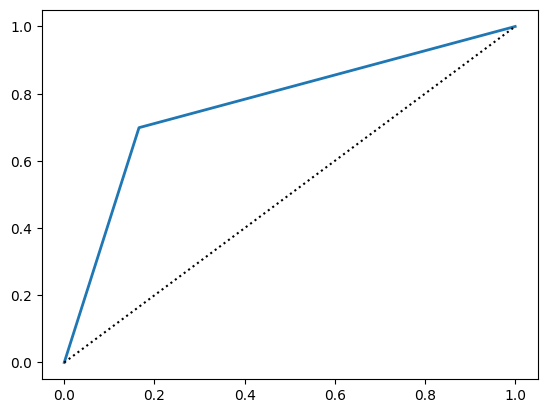

ROC AUC:  0.7665372447512222


In [50]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

fpr, tpr, thresholds = roc_curve(y_train, y_train_knn)

plt.plot(fpr, tpr, linewidth=2, label="ROC curve") 
plt.plot([0, 1], [0, 1], 'k:', label="Random classifier's ROC curve") 
plt.show()

print("ROC AUC: ",roc_auc_score(y_train, y_train_knn))

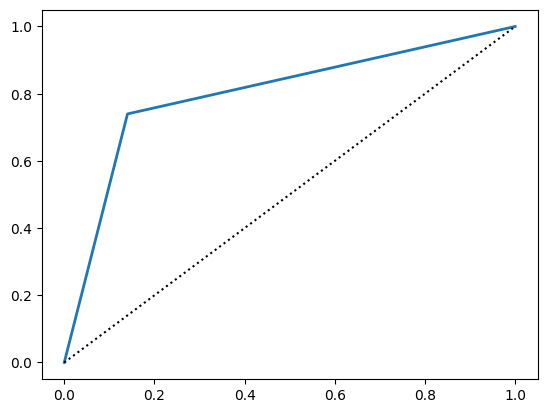

ROC AUC:  0.7997555363819385


In [51]:
fpr, tpr, thresholds = roc_curve(y_train, y_train_xgb)

plt.plot(fpr, tpr, linewidth=2, label="ROC curve") 
plt.plot([0, 1], [0, 1], 'k:', label="Random classifier's ROC curve") 
plt.show()

print("ROC AUC: ",roc_auc_score(y_train, y_train_xgb))

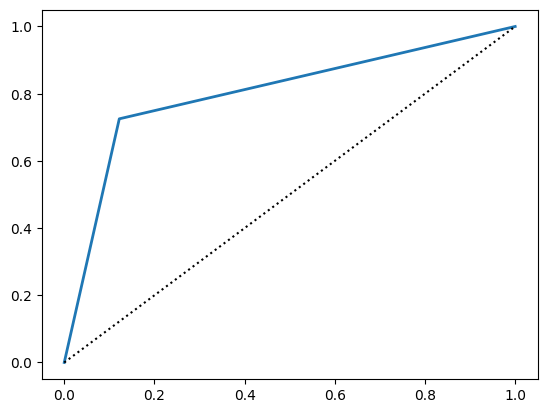

ROC AUC:  0.801553062985332


In [52]:
fpr, tpr, thresholds = roc_curve(y_train, y_train_svm)

plt.plot(fpr, tpr, linewidth=2, label="ROC curve") 
plt.plot([0, 1], [0, 1], 'k:', label="Random classifier's ROC curve") 
plt.show()

print("ROC AUC: ",roc_auc_score(y_train, y_train_svm))

ROC curve was not that useful in choosing between the models, as differences are barely distinguishable, yet using AUC we can put a number of it, and indeed it is barely different.

## Decision Threshold

But ROC curve is useful for shifting decision threshold of the models, and based on the confusion matrices we can see that all models are skewed to false negative mistakes. Let's see if we can balance it via shifting the decision threshold.

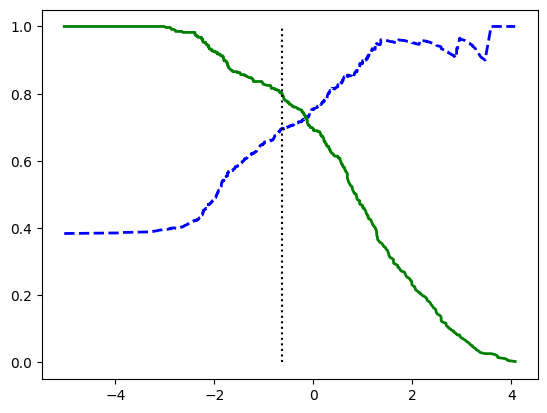

In [64]:
from sklearn.metrics import precision_recall_curve

y_scores_log = cross_val_predict(log, x_train, y_train, cv=5, method="decision_function")

precisions, recalls, thresholds = precision_recall_curve(y_train, y_scores_log)

# Quick method - threshold for max F1 score
f1_scores = 2 * (precisions[:-1] * recalls[:-1]) / (precisions[:-1] + recalls[:-1])
f1_scores = np.nan_to_num(f1_scores)
threshold = thresholds[np.argmax(f1_scores)]

plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2) 
plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2) 
plt.vlines(threshold, 0, 1.0, "k", "dotted", label="threshold") 
[...] # beautify the figure: add grid, legend, axis, labels, and circles 
plt.show()

Here I quickly found out that only log and svm models have decision thresholds. But their precision-recall curves are indeed quiet different.

Not going to lie, here I do feel out of my depth with decision thresholds and how they influence the false negative/ false positive rates. I did basic changing of decision threshold for log model to see how it influences sensitivity and specificity rates, we'll leave it at here for now.

## Finetuning
Not surprisingly, xgboost performs the best. I'll proceed to finetune it.

Well, change of results, now SVM is doing better on cross validation. I'll test xgboost first, and then maybe finetune svm in a new version.

In [75]:
from sklearn.model_selection import GridSearchCV

# From claude I got these parameters for finetuning
svm_params = {
    'C': [1, 10, 100],
    'gamma': ['scale', 0.01, 0.1],
    'kernel': ['rbf', 'linear']
}

# Run grid search
svm = SVC(random_state=42, probability=True)
svm_grid = GridSearchCV(
    svm, 
    svm_params, 
    cv=5, 
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

svm_grid.fit(x_train, y_train)
print(f"Best params: {svm_grid.best_params_}")
print(f"Best score: {svm_grid.best_score_:.4f}")

Fitting 5 folds for each of 18 candidates, totalling 90 fits
Best params: {'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}
Best score: 0.8204


# Submission

In [ ]:
# Predict on scaled test data
test_preds = svm_grid.predict(x_test)

# Build Kaggle submission file
submission = pd.DataFrame({
    "PassengerId": test['PassengerId'],
    "Survived": test_preds
})

# Save to CSV
submission.to_csv("submission.csv", index=False)
print("Submission file created: submission.csv")